# Introduction to Deep Learning - Assignment 1 Part 3 

In [2]:
import tensorflow as tf
import numpy as np
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
%matplotlib notebook #Need to execute twice due to instability of jupyter

UsageError: unrecognized arguments: #Need to execute twice due to instability of jupyter


In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Question 4 + 5 - Autoencoder with ADAM Optimizer

In [26]:
## All the functions required to complete question 4 and 5

'''
reshape_to_2D flattens the three dimensional training/test images to 2D array, 
for the convinience of analysis using Neural Network
Input x_3D: 3-dimensional array for images
Output x_2D: 2-dimensional array
'''
def reshape_to_2D(x_3D):
    x_2D = x_3D.reshape(x_3D.shape[0],x_3D.shape[1]**2)
    return x_2D


'''
Initialize parameters in the Neural Network
Input x: 2D array, usually the flattened training dataset
Input h: size of hidden layer
Output param: dictionary of parameters, including W1, W2, b1, b2
'''
def initialize(x,h=30):
    m,n = x.shape[0],x.shape[1]
    np.random.seed(1)
    
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = np.random.randn(h, n) * 0.01 #rough
    b1 = np.zeros(shape=(h, 1))
    
    W2 = np.random.randn(n, h) * 0.01 #rough
    b2 = np.zeros(shape=(n, 1))
    ### END CODE HERE ###
    
    assert(W1.shape == (h, n))
    assert(b1.shape == (h, 1))
    assert(W2.shape == (n, h))
    assert(b2.shape == (n, 1))
    
    param = {"W1": W1,
             "b1": b1,
             "W2": W2,
             "b2": b2}
    
    return param


'''
Sigmoid Function
Input z: 2D array
Output a: sigmoid function applied element-wise on z
'''
def sigmoid(z):
    a = 1.0/(1+np.exp(-z))
    return a


'''
phi chooses activation function to apply to a layer in the neural network
Input x: 2D array
Input phi_choice: string, name of the chosen activation function
Output: the chosen activation function applied on x, element-wise. 
'''
def phi_func(x,phi_choice):
    if phi_choice =='tanh':
        return np.tanh(x) #again, phi can be any function. maybe need to choose using cross validation OMG
    elif phi_choice =='relu':
        return np.maximum(x, 0, x)
    elif phi_choice =='sigmoid':
        return sigmoid(x)
    elif phi_choice =='leaky_relu':
        return np.maximum(x,0,-0.01*x)

    
'''
dphi computes the gradient of phi(x) w.r.t to x, given a chosen activation function
Input x: 2D array
Input phi_choice: string, string, name of the chosen activation function
Output: gradient computed element-wise on x
'''    
def dphi(x,phi_choice):
    if phi_choice =='tanh':
        return 1.0-np.tanh(x)**2
    elif phi_choice =='relu':
        return np.where(x > 0, 1.0, 0.0)
    elif phi_choice =='sigmoid':
        return sigmoid(x)*(1-sigmoid(x))
    elif phi_choice =='leaky_relu':
        return np.where(x > 0, 1.0, -0.01)


'''
forward_propagation encodes the original dataset, then decodes to produce an extracted version
Input param: dictionary of parameters
Input x: 2D array, original dataset
Input phi_choice: string, string, name of the chosen activation function
Output tree: dictionary of all layers (2D arrays) in the neural network, including the encoded hidden layer, tree['h'],
             and the decoded version of x, tree['x_hat'] 
''' 
def forward_propagation(param, x, phi_choice):
    tree = {}
    W1 = param['W1']
    b1 = param['b1']
    W2 = param['W2']
    b2 = param['b2']
    tree['x'] = x
    tree['z1'] =  x@ W1.T + b1.T 
    tree['h'] = phi_func(tree['z1'],phi_choice)
    tree['z2'] = tree['h']@ W2.T +b2.T
    tree['x_hat'] = sigmoid(tree['z2']) 
    return tree



'''
square_loss calculates sum (halved) of square differences between the original dataset and the autoencoded dataset
Input x: 2D array, original dataset
Input y: 2D array, encoded-decoded dataset  
Output loss: scalar
''' 
def square_loss(x,y):
    m = x.shape[0]
    diff = x-y
    loss = (1.0/2)*np.sum(np.sum(np.power(diff,2))) #Hadamard product
    assert(loss.shape == ())
    return loss


'''
cross_entropy_loss calculates cross entropy error between original dataset and the autoencoded dataset
Input x: 2D array, original dataset
Input y: 2D array, encoded-decoded dataset  
Output loss: scalar
''' 
def cross_entropy_loss(x,y):
    loss = np.sum(np.sum(-x* np.log(y) - (1-x)* np.log(1-y)))
    assert(loss.shape == ())
    return loss


'''
Backpropagation computes the gradient of chosen cost function w.r.t each parameter in the neural network
This is the hand-written version. 
Input tree: dictionary of all layers (2D arrays) in the neural network
Input param: dictionary of parameters, including W1, W2, b1, b2
Input phi_choice: string, string, name of the chosen activation function
Input cost_func: string, string, name of the chosen cost function
Output grads: dictionary of gradients (2D/1D arrays) of cost function w.r.t to parameters
''' 
def handwritten_backpropagation(tree,param,phi_choice,cost_func='MSE'):
    #depends on the choice of phi and sigma function?
    m = tree['x'].shape[0]
    
    grads = {}
    
    if cost_func == 'MSE':
        dx_hat = (-1)*(tree['x'] - tree['x_hat']) #dL = 60000 x 28^2
    elif cost_func == 'CE':
        dx_hat = -(tree['x']/tree['x_hat']) + (1-tree['x'])/(1-tree['x_hat']) 
        
    dz2 = dx_hat*(tree['x_hat']*(1-tree['x_hat']))# element wise multipliction, 60000 x 28^2
    
    if phi_choice !='sigmoid':
        dz1 = ((dz2 @ (param['W2'])) * dphi(tree['z1'],phi_choice)) #60000 x 30
    else:
        dz1 = ((dz2 @ (param['W2'])) *(tree['h'] * (1-tree['h'])))
        
    
    grads['dW2'] = dz2.T @ tree['h'] #28^2 * 30, 28^2 *60000,60000x 30
    grads['dW1'] = dz1.T @ tree['x']  #600000 x 30.T, 60000 x 28^2, = 30 x 28^2
        
    
    grads['db2'] =  np.sum(dz2, axis=0, keepdims=True).T #shape = (28^2,1) 
    grads['db1'] = np.sum(dz1,axis=0,keepdims=True).T #(30, 1)
    
    return grads


'''
Backpropagation computes the gradient of chosen cost function w.r.t each parameter in the neural network
This is the version according to our answers in Q3, reverse mode AutoDiff. 
Input tree: dictionary of all layers (2D arrays) in the neural network
Input param: dictionary of parameters, including W1, W2, b1, b2
Input phi_choice: string, string, name of the chosen activation function
Input cost_func: string, string, name of the chosen cost function
Output grads: dictionary of gradients (2D/1D arrays) of cost function w.r.t to parameters
''' 
def autodiff_backpropagation(tree,param,phi_choice,cost_func='MSE'):
    m = tree['x'].shape[0]
    n = tree['x'].shape[1]
    grads = {}
    
    if cost_func == 'MSE':
        df7df6 = (-1)*(tree['x'] - tree['x_hat']) 
    elif cost_func == 'CE':
        df7df6 = -(tree['x']/tree['x_hat']) + (1-tree['x'])/(1-tree['x_hat']) 
        
    df6df5 = tree['x_hat']*(1-tree['x_hat'])
    df5df4 = 1
    df4df3 = param['W2']
    
    if phi_choice !='sigmoid':
        df3df2 = dphi(tree['z1'],phi_choice)
    else:
        df3df2 = (tree['h'] * (1-tree['h']))
    
    grads['dW2'] = (df7df6*df6df5*df5df4).T @ tree['h']
    grads['dW1'] = ((df7df6*df6df5*df5df4) @ df4df3 * df3df2).T @ tree['x']  
    
    grads['db2'] = (np.sum(df7df6*df6df5*df5df4,axis=0,keepdims=True)).T
    grads['db1'] =  (np.sum((df7df6*df6df5*df5df4) @ df4df3 * df3df2, axis=0,keepdims=True)).T
    
    return grads
    
'''
Initialize the first and second moments of gradients of loss w.r.t parameters for the ADAM Optimizer, 
according to the dimension of parameters
Input param: dictionary of parameters
Output m: dictionary of 1st moments
Output v: dictionary of 2nd moments
'''
def initialize_adam_optimizer(param):
    m = {}
    v = {}
    L = len(param) // 2
    
    for l in range(L):
        m["dW" + str(l + 1)] = np.zeros_like(param["W" + str(l + 1)])
        m["db" + str(l + 1)] = np.zeros_like(param["b" + str(l + 1)])

        v["dW" + str(l+1)] = np.zeros_like(param["W" + str(l + 1)])
        v["db" + str(l+1)] = np.zeros_like(param["b" + str(l + 1)])
    
    return m,v


'''
Update gradients, moments and parameters using Adam Optimizer, given 1st and 2nd moments. 
Input param: dictionary of parameters
Input grads: dictionary of gradients
Input m: dictionary of 1st moments, at the current interation
Input v: dictionary of 2nd moments, at the current interation
Input learning_rate: float
Input b1: float
Input b2: float
Input gamma: float
Output m:: updated dictionary of 1st moments, ready to use for the next iteration
Output v: updated dictionary of 2nd moments, ready to use for the next iteration
Output param: updated dictionary of parameters
'''

def update_adam_optimizer(param,grads,m,v,learning_rate,t,b1=0.9,b2=0.999,gamma=10**(-8)):
    L = len(param) // 2   #number of parameters
    
    m_hat = {}
    v_hat = {}
    
    for l in range(L):
        m["db" + str(l + 1)] = b1 * m["db" + str(l + 1)] + (1 - b1) * grads['db' + str(l + 1)]
        v["db" + str(l + 1)] = b2 * v["db" + str(l + 1)] + (1 - b2) * np.power(grads['db' + str(l + 1)], 2)
        m_hat["db" + str(l + 1)] = m["db" + str(l + 1)] / (1 - np.power(b1, t))
        v_hat["db" + str(l + 1)] = v["db" + str(l + 1)] / (1 - np.power(b2, t))
        param["b" + str(l + 1)] = param["b" + str(l + 1)] - learning_rate * m_hat["db" + str(l + 1)] / np.sqrt(v_hat["db" + str(l + 1)] + gamma)
     
    for l in range(L):
        m["dW" + str(l + 1)] = b1 * m["dW" + str(l + 1)] + (1 - b1) * grads['dW' + str(l + 1)]
        v["dW" + str(l + 1)] = b2 * v["dW" + str(l + 1)] + (1 - b2) * np.power(grads['dW' + str(l + 1)], 2)
        m_hat["dW" + str(l + 1)] = m["dW" + str(l + 1)] / (1 - np.power(b1, t))
        v_hat["dW" + str(l + 1)] = v["dW" + str(l + 1)] / (1 - np.power(b2, t))
        param["W" + str(l + 1)] = param["W" + str(l + 1)] - learning_rate * m_hat["dW" + str(l + 1)] / np.sqrt(v_hat["dW" + str(l + 1)] + gamma)

    return m,v,param


In [7]:
'''
This is the main Autoencoder function, that processes the original dataset iteratively via NN for extraction  
Input iterations: integer, maximum number of iterations executed
Input x_train: 3D array, original dataset straight from MNIST
Input phi_choice: string, name of the chosen activation function for hidden layer
Input cost_func: string, name of the chosen cost function
Output learning_rate: float, learning rate for ADAM Optimizer, default at 0.001
Output minibatch_size: integer, number of training data in a minibatch, default at 100
'''

def autoencoder(iterations,x_train,phi_choice='relu', cost_func='MSE',learning_rate = 0.001,minibatch_size = 100, epsilon=1*10^(-3)): 
    l = x_train.shape[0]
    n = x_train.shape[1]
    x_train = reshape_to_2D(x_train)
    param  = initialize(x_train,h=30)
    m,v = initialize_adam_optimizer(param)  
    num_batches = int(l/minibatch_size)
    batch_costs = np.zeros(num_batches)
    average_costs = np.zeros(iterations)
    prev_average_cost = 20000 #initialize 
    cost_diff = 10000
    i = 1
    
    
    while (cost_diff> epsilon) & (i< iterations):
    #for i in np.arange(1,iterations+1): #start from i=1
        startTime = datetime.now()
        np.random.shuffle(x_train) #Shuffle the x_train array at each iteration
        
        for k in range(0, l, minibatch_size):
            batch_num = k/(minibatch_size)
            x_train_mini = x_train[k:k + minibatch_size]
        
            tree = forward_propagation(param, x_train_mini, phi_choice)

            startTime = datetime.now()
            if cost_func =='MSE':
                cost = square_loss(tree['x'],tree['x_hat'])/minibatch_size
            elif cost_func =='CE':
                cost = cross_entropy_loss(tree['x'],tree['x_hat'])/minibatch_size
            batch_costs[int(batch_num)] = cost
            
            startTime = datetime.now()
            grads = autodiff_backpropagation(tree,param,phi_choice,cost_func)   

            startTime = datetime.now()
            m,v,param = update_adam_optimizer(param,grads,m,v,learning_rate,i)
        
        #Calculate the average cost across mini-batches, and compare with the previous average cost. 
        average_cost = batch_costs.mean()
        average_costs[i-1] = average_cost
        cost_diff = abs(average_cost - prev_average_cost)
        prev_average_cost = average_costs[i-1]
        
        i+=1
        
        if (i%10==0)&(i>0):
            print('i=',i)
            print('cost=', average_cost)
            
    return average_costs[average_costs!=0],tree, param

# Mean Square Error

### Choosing the best Phi function for Square Loss (not included in the assignment)

First, experiment with different phi functions including tanh, relu, leaky relu and sigmoid, in order to find the best performing one. Set the maximum iteration to 10 just to observe the main trend of convergence. 

i= 10
cost= 25.39474234676751
0:00:44.512508


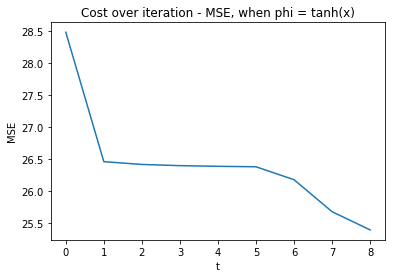

In [27]:
#Phi = Tanh
startTime = datetime.now()

costs, _, _ = autoencoder(10,x_train,phi_choice='tanh')
print(datetime.now() - startTime)

fig = plt.plot(costs)
plt.xlabel('t')
plt.ylabel('MSE')
plt.title('Cost over iteration - MSE, when phi = tanh(x)')
plt.show()

i= 10
cost= 6.998983446149325
0:00:57.321738


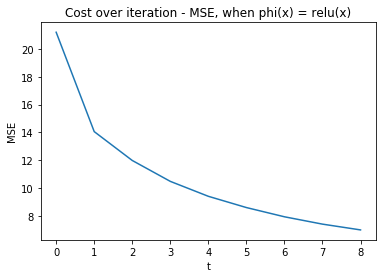

In [28]:
#Phi = Relu
startTime = datetime.now()

costs, _, _ = autoencoder(10,x_train,phi_choice='relu')
print(datetime.now() - startTime)

fig = plt.plot(costs.flatten())
plt.xlabel('t')
plt.ylabel('MSE')
plt.title('Cost over iteration - MSE, when phi(x) = relu(x)')
plt.show()

10 26.788792426724946
0:00:43.784597


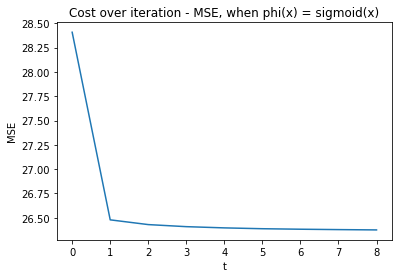

In [54]:
#Phi = sigmoid
startTime = datetime.now()
costs, _, _= autoencoder(10,x_train,phi_choice='sigmoid')
print(datetime.now() - startTime)

fig = plt.plot(costs)
plt.xlabel('t')
plt.ylabel('MSE')
plt.title('Cost over iteration - MSE, when phi(x) = sigmoid(x)')
plt.show()

10 6.207601518988352
0:00:45.836547


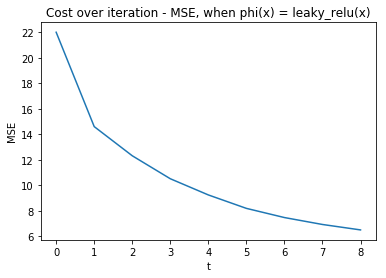

In [55]:
#phi = relu_leaky
startTime = datetime.now()
costs, _, _ = autoencoder(10,x_train,phi_choice='leaky_relu')
print(datetime.now() - startTime)

fig = plt.plot(costs)
plt.xlabel('t')
plt.ylabel('MSE')
plt.title('Cost over iteration - MSE, when phi(x) = leaky_relu(x)')
plt.show()

As shown by the average cost over iteration graphs above, the best performing phi function is Leaky Relu. 
Hence the rest of assignment using MSE will be carried out with $\phi(x)$ = leaky_relu(x)

## Training Error versus Iteration, for MSE with Leaky Relu

In [36]:
startTime = datetime.now()

costs_MSE, tree_MSE, param_MSE = autoencoder(100,x_train,phi_choice='leaky_relu')
print(datetime.now() - startTime)

i= 10
cost= 6.547442083677837
i= 20
cost= 4.793428078578446
i= 30
cost= 4.383993732791218
i= 40
cost= 4.27239077577571
i= 50
cost= 4.223802258398714
i= 60
cost= 4.197170828297518
i= 70
cost= 4.179072510679387
i= 80
cost= 4.166801356043606
i= 90
cost= 4.158146555414675
i= 100
cost= 4.151420869204684
0:08:35.094608


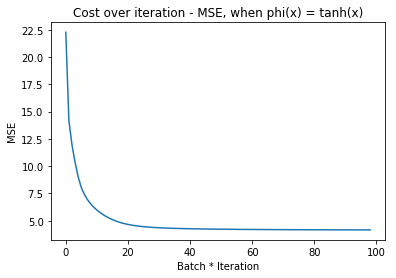

In [37]:
fig = plt.plot(costs_MSE.flatten())
plt.xlabel('Batch * Iteration')
plt.ylabel('MSE')
plt.title('Cost over iteration - MSE, when phi(x) = tanh(x)')
plt.show()

# Cross Entropy Error

### Choosing the best Phi function for Cross Entropy Loss (not included in the assignment)

i= 10
cost= 199.93764339155658
0:00:36.071128


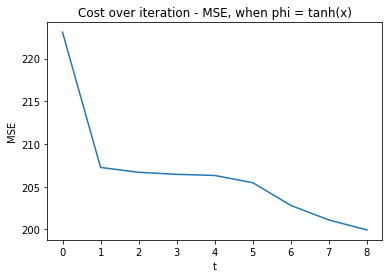

In [61]:
#Phi = Tanh
startTime = datetime.now()

costs, _, _ = autoencoder(10,x_train,phi_choice='tanh',cost_func='CE')
print(datetime.now() - startTime)

fig = plt.plot(costs)
plt.xlabel('t')
plt.ylabel('MSE')
plt.title('Cost over iteration - MSE, when phi = tanh(x)')
plt.show()

i= 10
cost= 206.12244104509946
0:00:38.995199


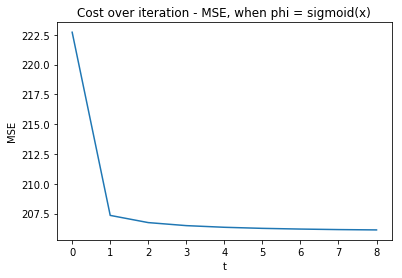

In [62]:
#Phi = sigmoid
startTime = datetime.now()

costs, _, _ = autoencoder(10,x_train,phi_choice='sigmoid',cost_func='CE')
print(datetime.now() - startTime)

fig = plt.plot(costs)
plt.xlabel('t')
plt.ylabel('MSE')
plt.title('Cost over iteration - MSE, when phi = sigmoid(x)')
plt.show()

i= 10
cost= 95.85921617081819
0:00:33.101086


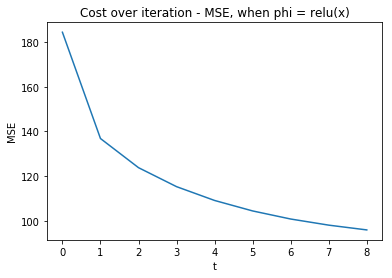

In [63]:
#Phi = relu
startTime = datetime.now()

costs, _, _ = autoencoder(10,x_train,phi_choice='relu',cost_func='CE')
print(datetime.now() - startTime)

fig = plt.plot(costs)
plt.xlabel('t')
plt.ylabel('MSE')
plt.title('Cost over iteration - MSE, when phi = relu(x)')
plt.show()

i= 10
cost= 88.45524698362938
0:00:31.032514


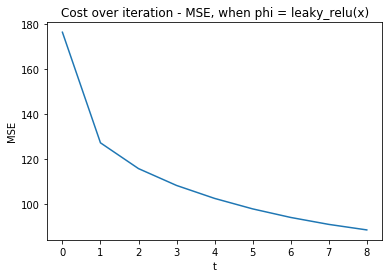

In [65]:
#Phi = leaky_relu
startTime = datetime.now()

costs, _, _ = autoencoder(10,x_train,phi_choice='leaky_relu',cost_func='CE')
print(datetime.now() - startTime)

fig = plt.plot(costs)
plt.xlabel('t')
plt.ylabel('MSE')
plt.title('Cost over iteration - MSE, when phi = leaky_relu(x)')
plt.show()

Leaky Relu is the best performing phi function. Hence the rest of the assignment will be carried out by setting phi = 'leaky_relu'

## Training Error versus Iteration, for CE with Leaky Relu

In [38]:
startTime = datetime.now()

costs_CE, tree_CE, param_CE = autoencoder(100,x_train,phi_choice='leaky_relu', cost_func='CE')
print(datetime.now() - startTime)


i= 10
cost= 89.70253059487281
i= 20
cost= 78.35688942365812
i= 30
cost= 76.11616937740858
i= 40
cost= 75.40257667652689
i= 50
cost= 75.07402728773089
i= 60
cost= 74.8877803418926
i= 70
cost= 74.76683028598788
i= 80
cost= 74.67689084662918
i= 90
cost= 74.61103841792512
i= 100
cost= 74.55348850703037
0:06:14.863142


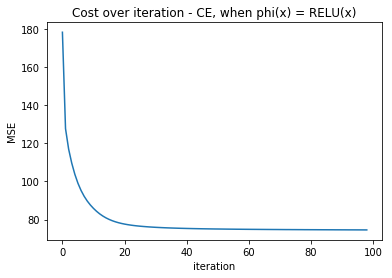

In [39]:
fig = plt.plot(costs_CE)
plt.xlabel('iteration')
plt.ylabel('MSE')
plt.title('Cost over iteration - CE, when phi(x) = RELU(x)')
plt.show()

## Comment on the differences between Mean Square Error and Cross Entropy Error

The main observation is that Cross Entropy Error is significantly higher than Mean Square Error, and given a fixed value of tolerance, Cross Entropy Error takes more epochs to converge than Mean Square Error. This implies that Cross Entropy Error may not be a suitable choice for Autoencoder on images. The reasons for this could be due to the assumptions of each loss function. 

The underlying assumption for MSE is that the intensity value of each pixel in $x_{test}$ and $\hat{x}$ are continuous, and $\hat{x}$ follows a Normal Distribution, $N(x_{test}, \sigma)$, where the variance is fixed. By using MSE, our autoencoder aims to obtain the same pixel intensity in the decoded image as the original image.

However, the underlying assumption for Cross Entropy is that each pixel in the original training image is binary, i.e. 0 or 1, and it regards the intensity value of each pixel in $\hat{x}$ as the probability of a pixel being 1, even though the pixel intensity should be continuous in [0,1]. By using CE, the goal of autoencoder becomes the maximisation of likelihood that pixel=1 in locations of the decoded image where the original image =1. 


# Reconstruct and plot 100 random examples

In [42]:
## Reconstruct and plot random 100 examples
'''
This function reconstructs x_hat from x_test, given the parameters previously trained by ADAM Optimizer
Input x_test: 3D array, the original tet dataset from MNIST
Input param: dictionary of parameters
Input phi_choice: string, string, name of the chosen activation function for hidden layer
Output x_hat: 2D array, reconstructed images in 2D
'''
def reconstruction(x_test,param,phi_choice='leaky_relu'):
    x_test = reshape_to_2D(x_test)
    
    W1 = param['W1']
    b1 = param['b1']
    W2 = param['W2']
    b2 = param['b2']
    
    z1 =  x_test @ W1.T + b1.T 
    h = phi_func(z1,phi_choice)
    z2 = h @ W2.T +b2.T
    x_hat = sigmoid(z2) 
    
    return x_hat

In [41]:
'''
reshape_to_3D reshapes the reconstructed images (in 2D array) into 3D for the purpose of visualisation
Input x_2D: 2D array, the flattened version of reconstruction from MNIST dataset
Output x_3D: 3D array
'''
def reshape_to_3D(x_2D):
    x_3D = x_2D.reshape(x_2D.shape[0],int(x_2D.shape[1]**(1/2)),int(x_2D.shape[1]**(1/2))) *255.0
    return x_3D


'''
Plot reconstructed images, in 10 x 10 grid
'''
def plot_100_xhat(x_hat,cost_func):
    x_hat = reshape_to_3D(x_hat)
    fig = plt.figure(figsize=(10,8))
        
    for i in range(100):
        ax = fig.add_subplot(10, 10, i+1)
        ax.imshow(x_hat[i], cmap='gray')
    
    fig.suptitle('Autoencoded Test Sample, with cost function: '+ cost_func)
    plt.show()


'''
Plot original test images, in 10 x 10 grid
'''    
def plot_100_xtest(x_test_sample):
    fig = plt.figure(figsize=(10,8)) 
    for i in range(100):
        ax = fig.add_subplot(10, 10, i+1)
        ax.imshow(x_test_sample[i], cmap='gray')
        ax.set_title("original")
    
    fig.suptitle('Original Test Sample')
    plt.show()

# Plotting 100 random autoencoded images vs. original

<IPython.core.display.Javascript object>


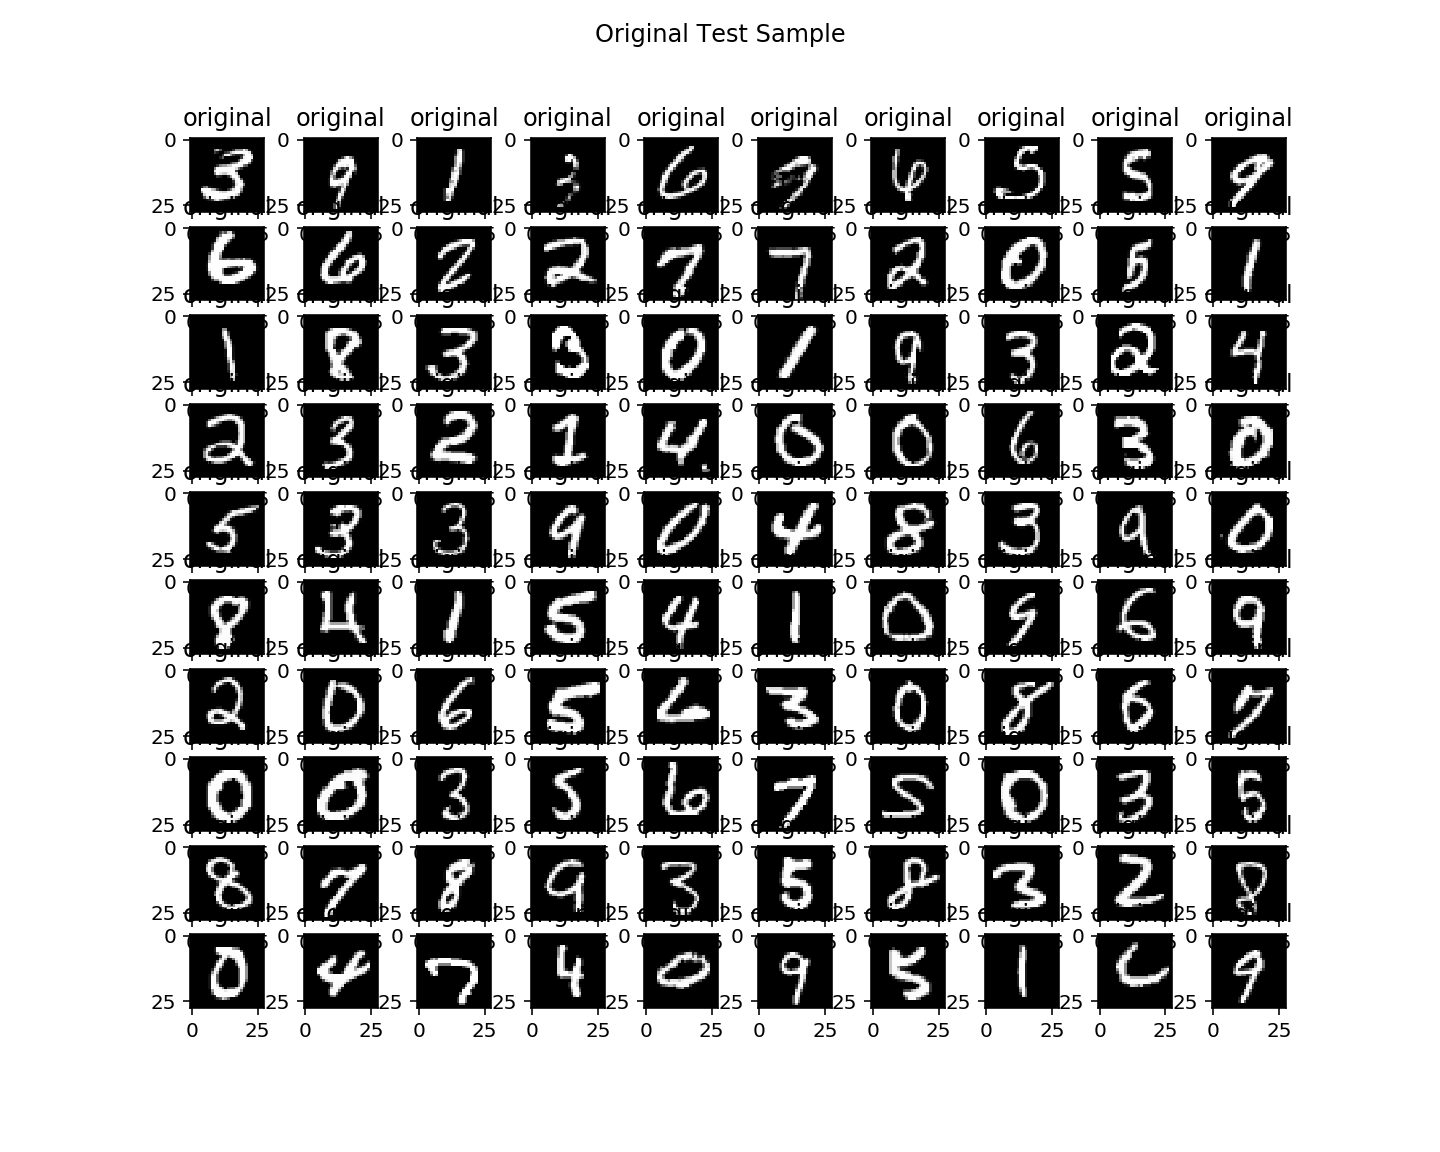

In [115]:
#Plot the original test sample
sample_loc=np.random.choice(range(x_test.shape[0]), 100, replace=False)
x_test_sample = x_test[sample_loc] 
plot_100_xtest(x_test_sample) 

<IPython.core.display.Javascript object>


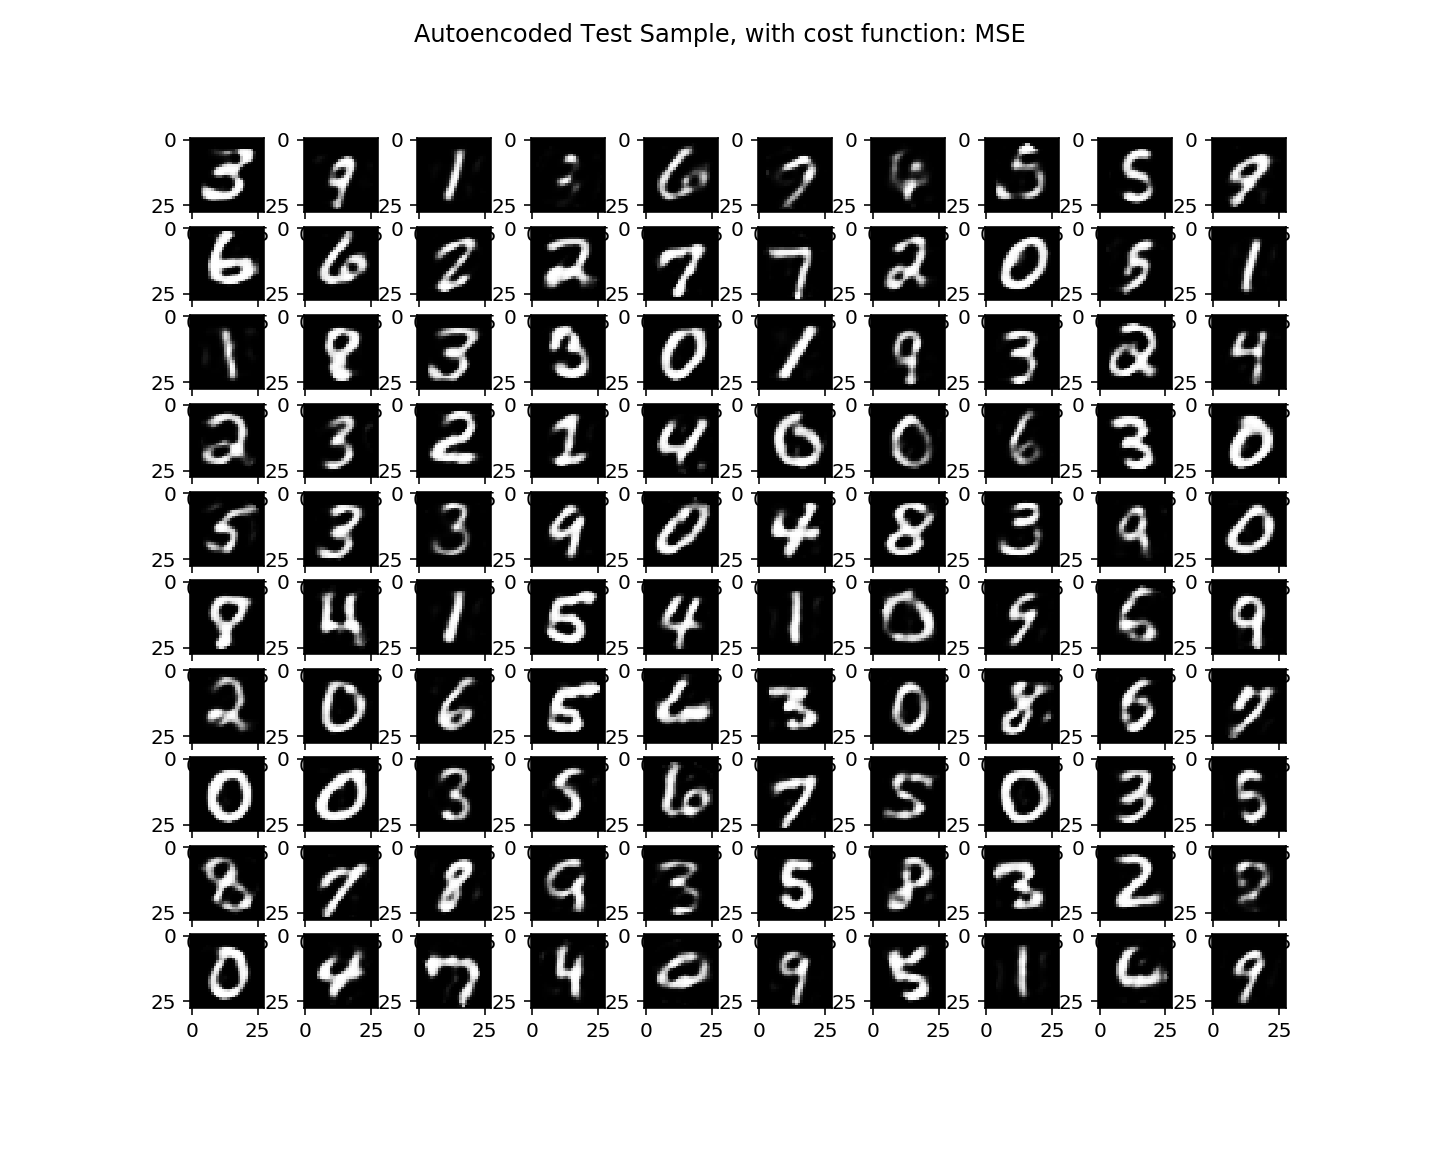

In [128]:
#Plot the autoencoded samples using MSE
x_hat = reconstruction(x_test_sample,param_MSE)
plot_100_xhat(x_hat,cost_func='MSE') 

<IPython.core.display.Javascript object>


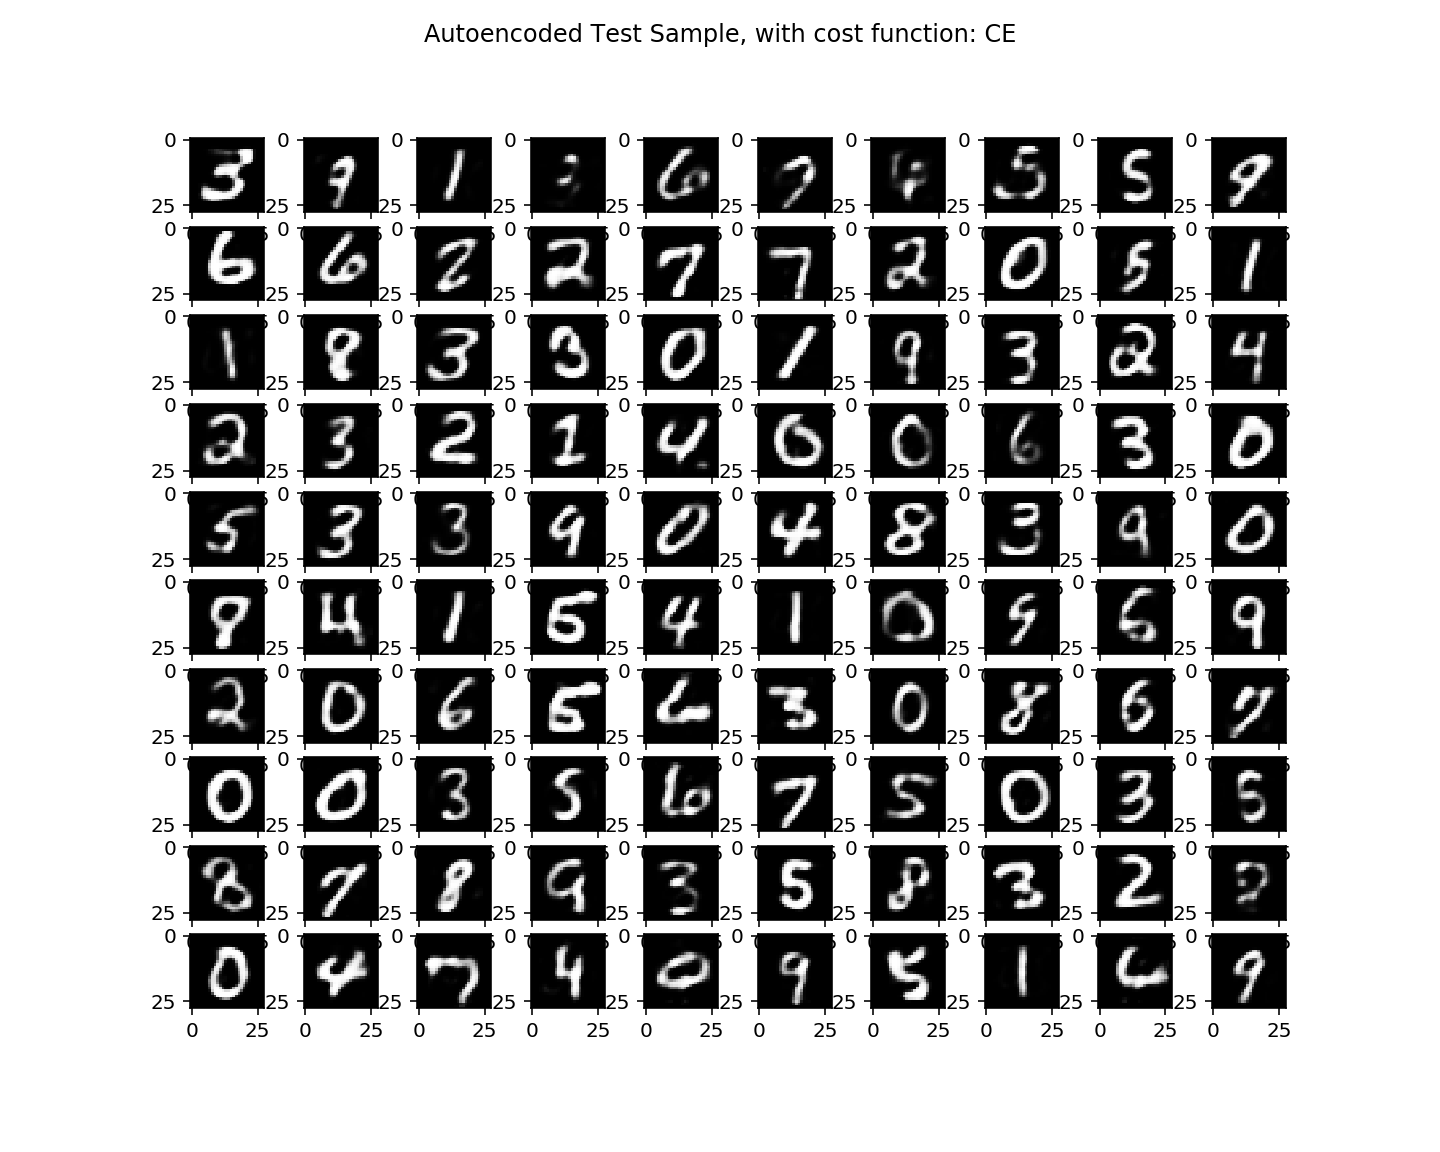

In [127]:
#Plot the autoencoded samples using MSE
x_hat = reconstruction(x_test_sample,param_CE)
plot_100_xhat(x_hat,cost_func='CE') 

# Q7 + Q8: Plot 2D slices of Autoencoder error

In [30]:
'''
slicing_error creates parameters with 'perturbation' of np.ones matices, given z1 and z2
and computes the corresponding F1, F2, F3 errors, and choice of cost function
Input x: 2D array
Input param: dictionary of parameters
Input z_vals: 1D array of size 2, [z1,z2]
Input cost_func: tring, name of the chosen cost function
'''
def slicing_error(x,param,z_vals,cost_func):
    W1 = param['W1']
    b1 = param['b1']
    W2 = param['W2']
    b2 = param['b2']
    z1 = z_vals[0]
    z2 = z_vals[1]
    
    h = W1.shape[0]
    n = W1.shape[1]
    
    param_f1 = {}
    param_f1['W1'] = W1+z1*np.ones((h,n))*(1.0/100)+z2*np.ones((h,n))*(1.0/100)
    param_f1['W2'] = W2
    param_f1['b1'] = b1
    param_f1['b2'] = b2
    
    param_f2 = {}
    param_f2['W1'] = W1+z1*np.ones((h,n))*(1.0/100)
    param_f2['W2'] = W2+z2*np.ones((n,h))*(1.0/100)
    param_f2['b1'] = b1
    param_f2['b2'] = b2
    
    param_f3 = {}
    param_f3['W1'] = W1
    param_f3['W2'] = W2+z1*np.ones((n,h))/100+z2*np.ones((n,h))/100
    param_f3['b1'] = b1
    param_f3['b2'] = b2
      
    F1 = error_given_parameters(x,param_f1,cost_func)
    F2 = error_given_parameters(x,param_f2,cost_func)
    F3 = error_given_parameters(x,param_f3,cost_func)
    return F1, F2, F3

In [31]:
'''
error_given_parameters computes one error value given input x and one set of parameters
Input x: 3D array, original test dataset from MNIST
Input param: dictionary of parameters
Input cost_func: tring, name of the chosen cost function
Output cost: float
'''

def error_given_parameters(x,param,cost_func='MSE'):
    #Compute error given parameters
    l = x.shape[0]
    x_auto = reconstruction(x,param)
    x = reshape_to_2D(x)
    
    if cost_func=='MSE':
        cost = square_loss(x,x_auto)/l
    elif cost_func =='CE':
        cost = cross_entropy_loss(x,x_auto)/l
    return cost

In [32]:
'''
create_parameter_space creates meshgrid, and pairwise arrays of values of z1 and z2 in [-2,2]
Input num_points: integer,number of intervals for z1(x) and z2(y) in [0,1]
Output grid_x: 2D array, covering all ranges of x defined by num_points
Output grid_y: 2D array, covering all ranges of y defined by num_points
Output xy_list: 2D array of dimension (num_points^2 x 2), pairwise values of z1 and z2
'''
def create_parameter_space(num_points):
    x_rng = np.linspace(-2, 2, num_points)
    y_rng = np.linspace(-2, 2, num_points)
    grid_x, grid_y = np.meshgrid(x_rng, y_rng)
    xy_list = np.column_stack((grid_x.flat, grid_y.flat))
    return grid_x,grid_y,xy_list

In [33]:
'''
compute_errors_over_2D loops over each pair of values of z1 and z2, calculates errors for F1, F2, F3
Input x_test: 3D array, original test dataset from MNIST
Input xy_list: 2D array of dimension (num_points^2 x 2), pairwise values of z1 and z2
Input param: dictionary of parameters
Input cost_func: tring, name of the chosen cost function
'''
def compute_errors_over_2D(x_test, xy_list, param, cost_func):
    num_pairs = xy_list.shape[0]
    F1_arr = np.zeros(num_pairs)
    F2_arr = np.zeros(num_pairs)
    F3_arr = np.zeros(num_pairs)
    startTime = datetime.now()

    for i in range(num_pairs):

        if i%100 ==0:
            print(i)
            print(datetime.now() - startTime)
        
        #print('x_test shape', x_test.shape)
        F1, F2, F3 = slicing_error(x_test,param,xy_list[i],cost_func)
        #print(xy_list[i])
        
        F1_arr[i] = F1
        F2_arr[i] = F2
        F3_arr[i] = F3

    return F1_arr,F2_arr,F3_arr

In [34]:
'''
Plot 3D images, given values of F1, F2, F3 over z1 and z2 in [0,1]
'''
def plot_3D(grid_x, grid_y, num_points,F1_arr,F2_arr,F3_arr,zlim=100):
    
    F1_grid = F1_arr.reshape((num_points, num_points))
    F2_grid = F2_arr.reshape((num_points, num_points))
    F3_grid = F3_arr.reshape((num_points, num_points))
    
    fig = plt.figure(figsize=(10,3))
    ax = fig.add_subplot(1, 3, 1, projection='3d') 
    surf = ax.plot_surface(grid_x, grid_y, F1_grid, rstride=1, cstride=1,
                           linewidth=0, antialiased=False)
    ax.set_zlim3d(0, zlim)
    ax.set_title('Mesh plot of F1')
    
    ax = fig.add_subplot(1, 3, 2, projection='3d')
    surf = ax.plot_surface(grid_x, grid_y, F2_grid, rstride=1, cstride=1,
                           linewidth=0, antialiased=False)
    ax.set_zlim3d(0, zlim)
    ax.set_title('Mesh plot of F2')
    

    ax = fig.add_subplot(1, 3, 3, projection='3d')
    surf = ax.plot_surface(grid_x, grid_y, F3_grid, rstride=1, cstride=1,
                           linewidth=0, antialiased=False)
    ax.set_zlim3d(0, zlim)
    ax.set_title('Mesh plot of F3')
    
    plt.show()


## Q7: Plot 2D Slice for MSE

0
0:00:00.000164


<IPython.core.display.Javascript object>


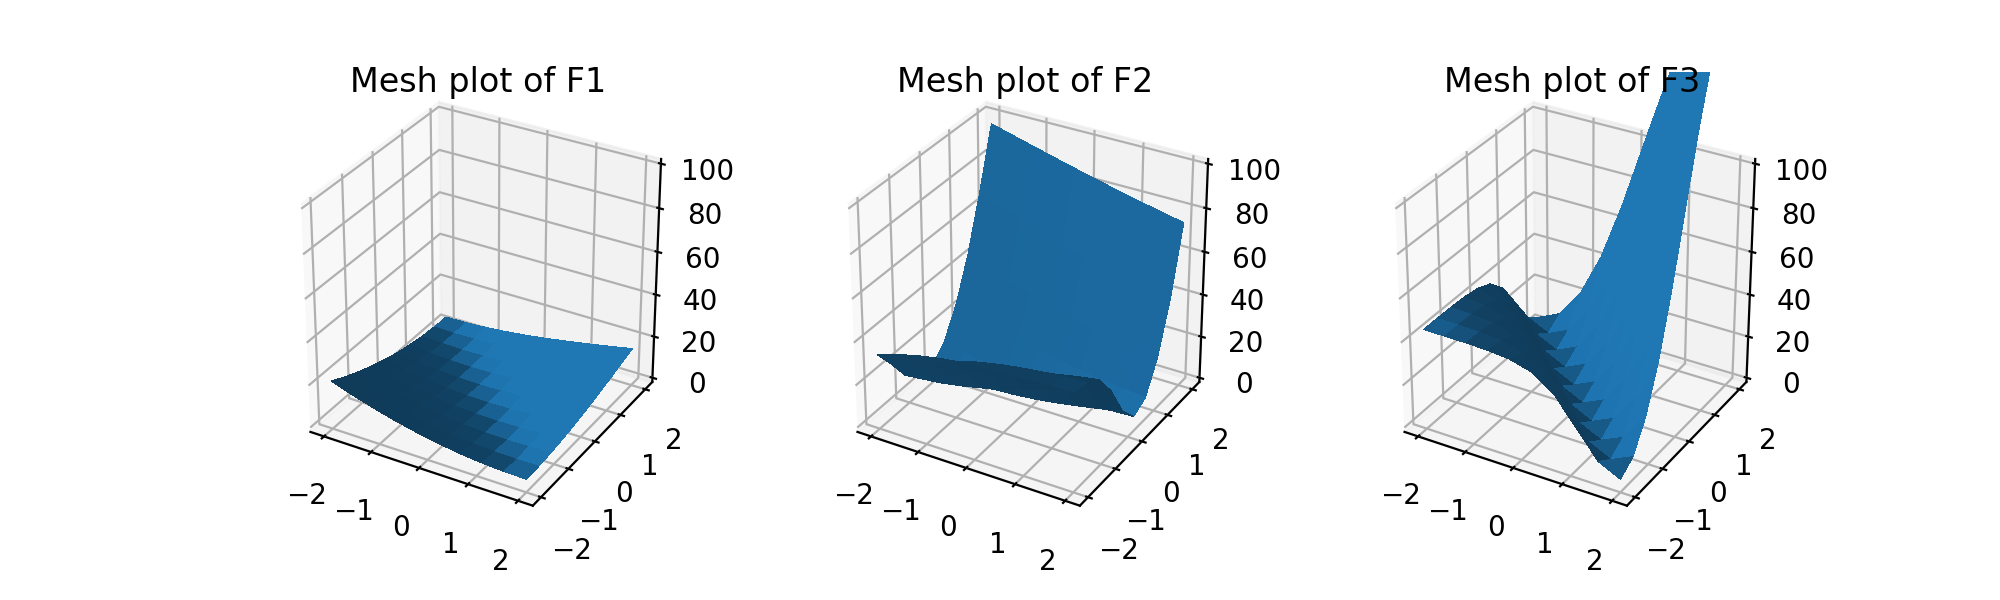

In [48]:
num_points=10
param = param_MSE
grid_z1,grid_z2,z1z2_list = create_parameter_space(num_points)
F1_arr,F2_arr,F3_arr = compute_errors_over_2D(x_test,z1z2_list, param, cost_func='MSE')
plot_3D(grid_z1, grid_z2, num_points,F1_arr,F2_arr,F3_arr)

## Q8: Plot 2D Slice for CE

0
0:00:00.000167


<IPython.core.display.Javascript object>


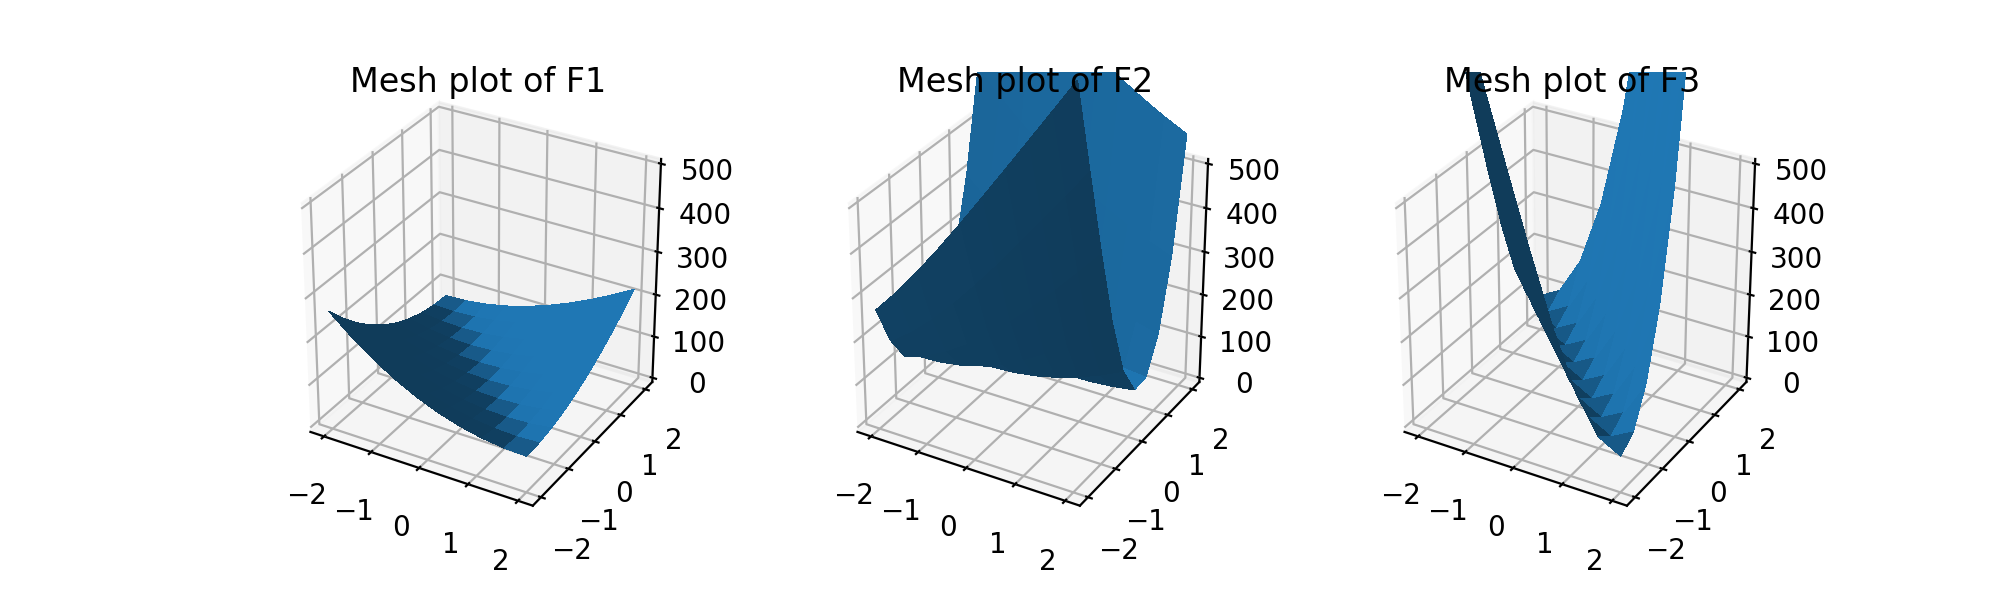

In [49]:
num_points=10
param = param_CE
grid_z1,grid_z2,z1z2_list = create_parameter_space(num_points)
F1_arr,F2_arr,F3_arr = compute_errors_over_2D(x_test,z1z2_list, param, cost_func='CE')
plot_3D(grid_z1, grid_z2, num_points,F1_arr,F2_arr,F3_arr,zlim=500)

The Cross Entropy Error increases more rapidly than Mean Square Error around the optimal parameters, as shown previously that CE is higher than MSE in general. 
But the surface of F3 calculated with MSE does not look perfectly convex. This is due to the fact that Mean Square Error is not convex in weights for non-linear problems, as proven in Exercise 1 question 3.